### SVMを使って集めた画像をひよこ鑑定

BeautifulSoupを使って画像を集めて、その画像をひよこかどうか判定する  
SVM(Support Vector Machine)を使って、分類を行う

まず、判定するための画像を検索サイトから画像を集めてきます   
便利ライブラリ、BeautifulSoupを使っていきます  
参考：http://stmind.hatenablog.com/entry/2014/01/15/012418

In [1]:
from bs4 import BeautifulSoup
import requests
import re
import urllib
import os

In [2]:
def make_url(query):
    return 'https://www.bing.com/images/search?q=' + query + '&FORM=HDRSC2'

In [3]:
def get_images(query):
    url = make_url(query)
    soup = BeautifulSoup(requests.get(url).text, 'lxml')
    imgs = [img['src'] for img in soup.find_all("img", {"src": re.compile("mm.bing.net")})]
    for idx, img in enumerate(imgs):
        raw_img = urllib.request.urlopen(img).read()
        with open("images/" + query + "_" + str(idx) + '.jpg', 'wb') as f:
            f.write(raw_img)

In [131]:
url = 'https://www.google.co.jp/search?q=cat&source=lnms&tbm=isch&sa=X&ved=0ahUKEwjwwsaZ3pTUAhXGfLwKHQfSAFUQ_AUIBigB&biw=1440&bih=826'
soup = BeautifulSoup(requests.get(url).text, 'lxml')
images = [a['src'] for a in soup.find_all("img", {"src": re.compile("image")})]
images

['https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTjT3kdqL555IwM5We8WKGPAWvZvIGW_IVjRSgaUR6gG3qI0Tjfeu97s_r1',
 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTM1gyfoLrqcuU-k9NLR8njIcjpIqiVxIDWr8M7FZEOCATGgDSQrxX8EFo',
 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQp3HxPf-MuF3xtl8M8xsKrk5Ra6sz9fbuzIZMtmKLVbRRpvioilIWf1cY',
 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT4R1BoeVU1M2WsexXyDMiV63zaMU0M_6XgkENR6fTEXRwSeJ_b4bAM229m',
 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQyMti4PdsmfG3twyUgKSU7dxD86WZK07e0Gg7QelFyGBggweI5vm1jZ_JY',
 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRt4EU0mI9f1vhcQY_UZOov-TKxKaHrsHX3kwVgsaCZzViG8_O0SpNJ0s_X',
 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQjPlK7k97vKZWvnvSXAKFErMI4mWXsHZ1goZbs-BSLAVDXtvLY3o_REn0',
 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZJxYSEAIf0v3NKVC7Sj2X3VMXefcv6gT9l27pERNIcipv9nDD132RDg',
 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRJyNVc64ILUED

In [4]:
query = ['chick', 'cat']
get_images(query[0])

In [5]:
get_images(query[1])

In [6]:
import matplotlib.pyplot as plt
from PIL import Image 
%matplotlib inline
plt.style.use('ggplot')

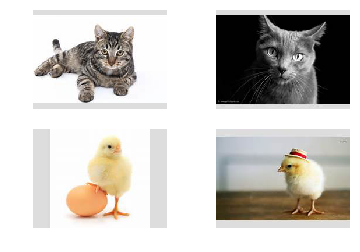

In [7]:
# 保存した画像を一部表示
plt.subplot(2, 2, 1)
img = Image.open('./images/cat_6.jpg')
plt.imshow(img)
plt.axis('off')

plt.subplot(2, 2, 2)
img = Image.open('./images/cat_23.jpg')
plt.imshow(img)
plt.axis('off')

plt.subplot(2, 2, 3)
img = Image.open('./images/chick_11.jpg')
plt.imshow(img)
plt.axis('off')

plt.subplot(2, 2, 4)
img = Image.open('./images/chick_13.jpg')
plt.imshow(img)
plt.axis('off')

plt.show()

### これで画像集め完了!
  
早速、　画像を分類してみましょう！  
使う手法はSVM（サポートベクターマシン）  
「マージン最大化」が特徴の識別器らしい...(別資料あり)  

In [8]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [9]:
img_dir = './images/'
images = [img_dir + fname for fname in os.listdir(img_dir) if fname.endswith('jpg')]
labels = [query[0] if query[0] in img.split('/')[-1] else query[1] for img in images]

In [10]:
data = []
for image in images:
    img = Image.open(image)
    img = np.asarray(img)
    shape = img.shape
    img = img.reshape(1, shape[0]*shape[1]*shape[2])[0]
    data.append(img)

In [11]:
data = np.array(data)

In [12]:
is_train = np.random.uniform(0, 1, len(data)) <= 0.7
is_chick = np.where(np.array(labels) == query[0], 1, 0)

In [13]:
train_x, train_y = data[is_train], is_chick[is_train]
train_x

array([[221, 221, 221, ..., 219, 219, 219],
       [221, 221, 221, ..., 221, 221, 221],
       [221, 221, 221, ..., 221, 221, 221],
       ..., 
       [227, 219, 217, ..., 220, 221, 223],
       [221, 221, 221, ..., 221, 221, 221],
       [221, 221, 219, ..., 221, 221, 221]], dtype=uint8)

In [14]:
# 主成分分析で次元を落とす
pca = PCA(n_components=2, svd_solver='randomized')
pca_result = pca.fit_transform(data)
pca_df = pd.DataFrame({'x': pca_result[:, 0], 'y': pca_result[:, 1], 'label': np.where(is_chick == 1, query[0], query[1])})
pca_df

,label,x,y
0,cat,-65.186069,-3013.058456
1,cat,2646.676672,5160.507962
2,cat,-12451.287821,-3449.297378
3,cat,16535.105985,-8261.458888
4,cat,-1984.598260,1220.439568
5,cat,-16150.893355,676.185283
6,cat,-10757.995764,3054.081435
7,cat,16863.742146,-5409.291689
8,cat,12257.868086,-5297.817510
9,cat,-447.343174,-2296.136472


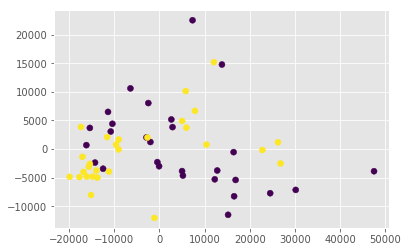

In [25]:
plt.scatter(pca_result[:,0], pca_result[:, 1], c=is_chick)
plt.show()

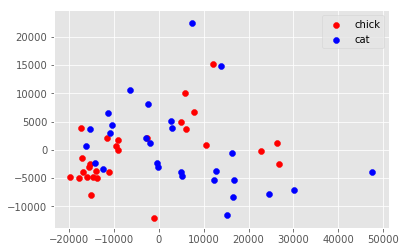

In [15]:
plt.scatter(pca_df[pca_df.label == query[0]]['x'], pca_df[pca_df.label == query[0]]['y'], color = 'red', label=query[0])
plt.scatter(pca_df[pca_df.label == query[1]]['x'], pca_df[pca_df.label == query[1]]['y'], color = 'blue', label=query[1])
plt.legend()
plt.show()

In [16]:
pca = PCA(n_components=5, svd_solver='randomized')
train_x = pca.fit_transform(train_x)

estimator = LinearSVC(C=1.0)
estimator.fit(train_x, train_y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [17]:
test_x, test_y = data[is_train == False], is_chick[is_train == False]
test_x = pca.transform(test_x)

In [18]:
confusion_matrix(test_y, estimator.predict(test_x))

array([[2, 3],
       [1, 6]])

In [19]:
accuracy_score(test_y, estimator.predict(test_x))

0.66666666666666663

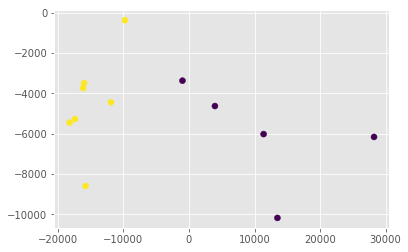

In [21]:
plt.scatter(test_x[:, 0], test_x[:, 1], c=test_y)
plt.show()

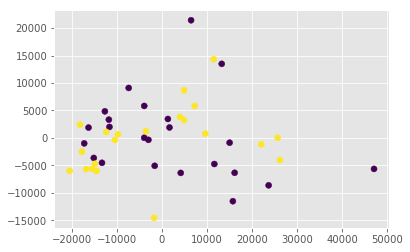

In [22]:
plt.scatter(train_x[:, 0], train_x[:, 1], c=train_y)
plt.show()